In [2]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import product, combinations
from IPython.display import display, Latex

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, HTML, Image

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

In [6]:
n_fock = 100
levels = 5

# Values in GHz (divided by h)
#Fluxonium A
ec = .973
el = .457
ej = 5.899 
flux = 1/2#pi in the cos

flx = pysqkit.qubits.Fluxonium('A', ec, el, ej, flux, dim_hilbert=n_fock)
flx.diagonalize_basis(levels)
energies, eig_states = flx.eig_states(levels)

<IPython.core.display.Javascript object>


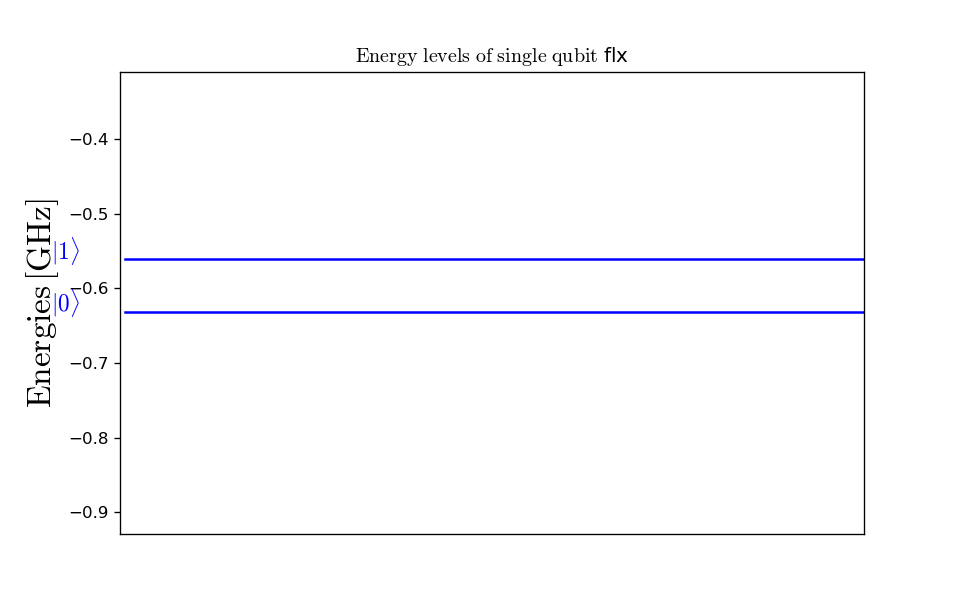

In [146]:
opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab = ["$| " + str(k) + " \\rangle $" for k in range(levels)]

def plot_energies_single(energies, text_lab, opt, name, ax):
    plt.figure()
    for k in range(0, levels):
        plt.plot([0,1], [energies[k]]*2, color='blue')
        plt.text(-0.1, energies[k], text_lab[k], fontsize=opt['fs_text'], color='blue')

    plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    plt.title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    plt.xlim(-.1, 1)
    ax = plt.gca()
    ax.xaxis.set_visible(False)

    

plot_energies_single(energies, text_lab, opt, "flx",  ax[0])

In [112]:
tan_delta_c = 2*10**(-6)
qdiel = 1/(2*tan_delta_c)

T = .02 #kelvin
h = 6.62607004 * 10**(-34)
kb = 1.38064852 * 10**(-23)
beta = 10**9 * h/(T*kb) #in order to be exp(beta * eigen energies)

print("This way the parameters are : \nBeta =", beta, "\nQdiel =", qdiel)


e = 1.60217662 *10**(-19)
R_eq = 4 * qdiel *h / (2*np.pi * e**2) #for omega ~ Ec ~1GHz 
print("\nThe equivalent resistor is R =", R_eq, "Ohm (nope)")

This way the parameters are : 
Beta = 2.3996223311056752 
Qdiel = 250000.0

The equivalent resistor is R = 4108235905.8229146 Ohm (nope)


In [157]:
qdiel = 1000
beta = 100

In [158]:
k = 0
m = 1

jump_m_k = flx.dielectric_jump(k, m, qdiel, beta, as_qobj = True)
print(jump_m_k[0]*1)
print(jump_m_k[1]*1)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 0.         -0.00315888  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.59762415e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [159]:
jump_diel = flx.dielectric_loss(qdiel, beta, as_qobj=True)

c:\users\nicol\git\qutech 2021\pysqkit\pysqkit\util\phys.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*energy) - 1)


In [160]:
tlist = np.linspace(0, 10**5, 100000)

state_in = 1/np.sqrt(5) * (qtp.Qobj(eig_states[0]) + \
                           qtp.Qobj(eig_states[1]) + \
                           qtp.Qobj(eig_states[2]) + \
                           qtp.Qobj(eig_states[3]) + \
                           qtp.Qobj(eig_states[4]) )
rho_in = state_in*state_in.dag()

hamil0 = flx.hamiltonian(as_qobj=True)
 

In [161]:
deb = time.time()
result = solvkit.integrate(tlist, rho_in, hamil0, [], [], jump_diel, "mesolve")
print("It took :", time.time() - deb, "seconds")

In [162]:
rho_0 = qtp.Qobj(eig_states[0]) * qtp.Qobj(eig_states[0]).dag()
rho_1 = qtp.Qobj(eig_states[1]) * qtp.Qobj(eig_states[1]).dag()
rho_2 = qtp.Qobj(eig_states[2]) * qtp.Qobj(eig_states[2]).dag()
rho_3 = qtp.Qobj(eig_states[3]) * qtp.Qobj(eig_states[3]).dag()
rho_4 = qtp.Qobj(eig_states[4]) * qtp.Qobj(eig_states[4]).dag()

<IPython.core.display.Javascript object>


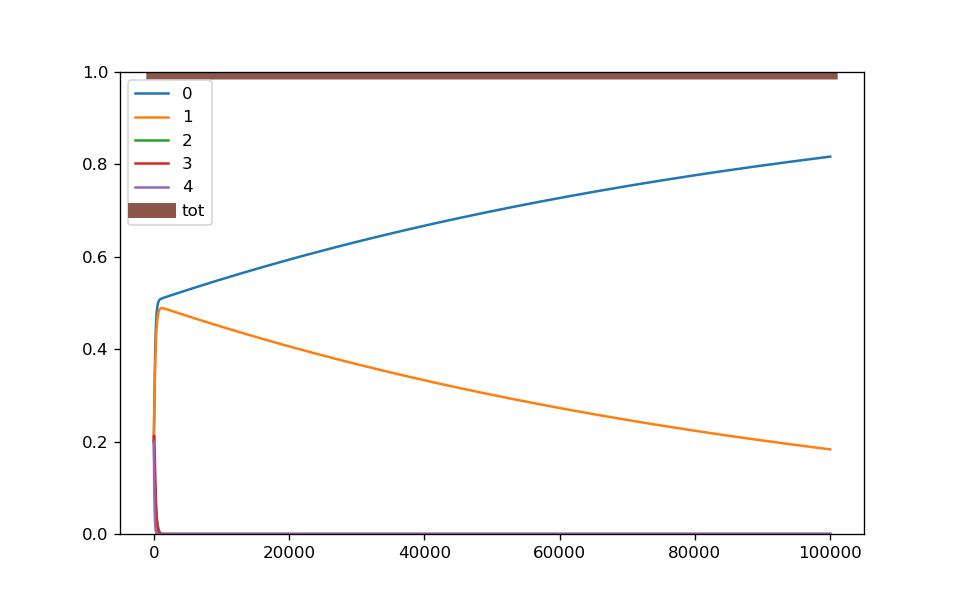

In [163]:
plt.figure()

expct_0 = np.array([qtp.expect(result.states[k], rho_0) for k in range(len(tlist))])
expct_1 = np.array([qtp.expect(result.states[k], rho_1) for k in range(len(tlist))])
expct_2 = np.array([qtp.expect(result.states[k], rho_2) for k in range(len(tlist))])
expct_3 = np.array([qtp.expect(result.states[k], rho_3) for k in range(len(tlist))])
expct_4 = np.array([qtp.expect(result.states[k], rho_4) for k in range(len(tlist))])

plt.plot(tlist, expct_0, label = '0')
plt.plot(tlist, expct_1, label = '1')
plt.plot(tlist, expct_2, label = '2')
plt.plot(tlist, expct_3, label = '3')
plt.plot(tlist, expct_4, label = '4')

plt.plot(tlist, expct_0 + expct_1 + expct_2 + expct_3 + expct_4, label = 'tot', linewidth = 9)

plt.ylim([0, 1])

plt.legend()